In [4]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
print(tf.__version__)

# add callbacks

2.4.1


In [5]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84131840/84125825 [==============================] - 5s 0us/step


In [6]:
print(dataset)
print(dataset_dir)

./aclImdb_v1.tar.gz
./aclImdb


In [7]:
os.listdir(dataset_dir)

['test', 'README', 'imdb.vocab', 'imdbEr.txt', 'train']

In [8]:
! ls ./aclImdb

imdbEr.txt  imdb.vocab	README	test  train


In [13]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'unsupBow.feat',
 'neg',
 'pos',
 'urls_unsup.txt',
 'unsup',
 'urls_neg.txt',
 'urls_pos.txt']

In [14]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [95]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

FileNotFoundError: [Errno 2] No such file or directory: './aclImdb/train/unsup'

In [2]:
batch_size = 8
seed = 42

imdb_reviews = 'aclImdb/train'
imdb_reviews_test = 'aclImdb/test'

medical_notes_dir = '/home/muody/data/medicalnotes/dataset/train-data'
medical_notes_dir_test = '/home/muody/data/medicalnotes/dataset/unlabeled-test-data'

raw_data = imdb_reviews
test_data = imdb_reviews_test

raw_data = medical_notes_dir
test_data = medical_notes_dir


raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    raw_data, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

NameError: name 'tf' is not defined

In [3]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

NameError: name 'raw_train_ds' is not defined

In [31]:
for i in range(len(raw_train_ds.class_names)):
    print("Label {} corresponds to".format(i), raw_train_ds.class_names[i])

Label 0 corresponds to Gastroenterology
Label 1 corresponds to Neurology
Label 2 corresponds to Orthopedic
Label 3 corresponds to Radiology
Label 4 corresponds to Urology


In [32]:
# VALIDATION
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    raw_data, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 826 files belonging to 5 classes.
Using 165 files for validation.


In [33]:
# TEST
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    test_data, 
    batch_size=batch_size)

Found 826 files belonging to 5 classes.


In [34]:
# remove html tags
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    stripped_html = tf.strings.regex_replace(stripped_html, '\n', ' ')
    stripped_html = tf.strings.regex_replace(stripped_html, '</B>', ' ')
    stripped_html = tf.strings.regex_replace(stripped_html, '<B>', ' ')
    stripped_html = tf.strings.unicode_transcode(stripped_html, "UTF-8", "UTF-8")
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [35]:
max_features = 100000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [36]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [37]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [38]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'\n\n\n\n\n<B>CC:</B> Sudden onset blindness.\n\n<B>HX:</B> This 58 y/o RHF was in her usual healthy state, until 4:00PM, 1/8/93, when she suddenly became blind. Tongue numbness and slurred speech occurred simultaneously with the loss of vision. The vision transiently improved to &quot;severe blurring&quot; enroute to a local ER, but worsened again once there. While being evaluated she became unresponsive, even to deep noxious stimuli. She was transferred to UIHC for further evaluation. Upon arrival at UIHC her signs and symptoms were present but markedly improved.\n\n<B>PMH:</B> 1) Hysterectomy many years previous. 2) Herniorrhaphy in past. 3) DJD, relieved with NSAIDs.\n\n<B>FHX/SHX:</B> Married x 27yrs. Husband denied Tobacco/ETOH/illicit drug use for her.\n\nUnremarkable FHx.\n\n<B>MEDS:</B> none.\n\n<B>EXAM:</B> Vitals: 36.9C.  HR 93.  BP 151/93.  RR 22.  98% O2Sat.\n\nMS: somnolent, but arousable to verbal stimulation. minimal speech. followed simple commands on

In [39]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[163])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[193])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  bpreoperative
 313 --->  condition
Vocabulary size: 15475


In [40]:
# testing replace
eagertensor = tf.strings.regex_replace("\n\n\n\n\n<B>PREOPERATIVE DIAGNOSIS: </B>","</B>", "")
result = eagertensor.numpy()
result.decode('utf-8')

'\n\n\n\n\n<B>PREOPERATIVE DIAGNOSIS: '

In [41]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [42]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [43]:
embedding_dim = 64

In [44]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(5)])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          6400064   
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 6,400,389
Trainable params: 6,400,389
Non-trainable params: 0
_________________________________________________________________


In [45]:
loss = losses.SparseCategoricalCrossentropy()
#loss = losses.BinaryCrossentropy
#losses.BinaryCrossentropy(from_logits=True)
model.compile(loss=loss,
              optimizer='adam',
              metrics='accuracy')

In [46]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
83/83 [==============================] - 3s 29ms/step - loss: 2.9960 - accuracy: 0.3259 - val_loss: 1.6094 - val_accuracy: 0.3212
Epoch 2/10
83/83 [==============================] - 2s 27ms/step - loss: 1.5788 - accuracy: 0.3210 - val_loss: 1.6094 - val_accuracy: 0.2788
Epoch 3/10
83/83 [==============================] - 2s 29ms/step - loss: 1.5909 - accuracy: 0.3691 - val_loss: 1.6094 - val_accuracy: 0.2848
Epoch 4/10
83/83 [==============================] - 2s 27ms/step - loss: 1.5909 - accuracy: 0.3234 - val_loss: 1.6094 - val_accuracy: 0.2788
Epoch 5/10
83/83 [==============================] - 2s 28ms/step - loss: 1.5789 - accuracy: 0.3872 - val_loss: 1.6094 - val_accuracy: 0.2727
Epoch 6/10
83/83 [==============================] - 2s 28ms/step - loss: 1.5789 - accuracy: 0.3460 - val_loss: 1.6094 - val_accuracy: 0.2727
Epoch 7/10
83/83 [==============================] - 2s 27ms/step - loss: 1.5789 - accuracy: 0.3292 - val_loss: 1.6094 - val_accuracy: 0.2727
Epoch 8/10
83

In [47]:
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

104/104 [==============================] - 0s 3ms/step - loss: 1.6036 - accuracy: 0.2978
Loss:  1.6035913228988647
Accuracy:  0.2978208363056183


In [48]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

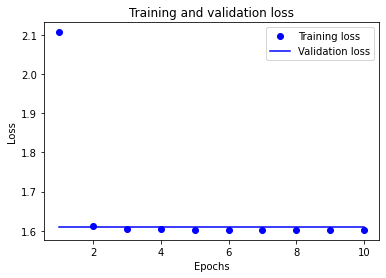

In [49]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

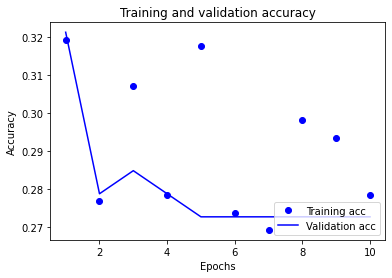

In [50]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()